# Convolutional Variational Autoencoder using the MNIST dataset (TensorFlow backend)

## Introduction to CVAE

CVAEs are Convolutional Variational Autoencoders. They are composed of two models using convolutions: an encoder to cast the input into a latent dimension, and a decoder that will move data from the latent dimension back to the input space. The figure below illustrates the main idea behind CVAEs. 


In this example, we will use a CVAE to generate data similar to the MNIST dataset using the TensorFlow backend. All training details including model structure, data preprocessing, loss calculation, etc. come from the [TensorFlow CVAE tutorial](https://www.tensorflow.org/tutorials/generative/cvae)
![cvae](./VAE_complete.png)[img source: https://mlexplained.com/2017/12/28/an-intuitive-explanation-of-variational-autoencoders-vaes-part-1]

## Import the required libraries

In [1]:
import tensorflow as tf
import fastestimator as fe
import numpy as np
import tempfile
import matplotlib.pyplot as plt
from typing import Any, Dict, Tuple

In [2]:
#training parameters
epochs = 20
batch_size = 100
max_train_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

In [3]:
# Parameters
epochs = 2
batch_size = 8
max_train_steps_per_epoch = 10


## Step 1 - Data and `Pipeline` preparation
In this step, we will load MNIST training and validation dataset and prepare FastEstimator's data `Pipeline`.

### Load dataset 
Let's use a FastEstimator API to load the MNIST dataset: 

In [4]:
from fastestimator.dataset.data.mnist import load_data

train_data, test_data = load_data()

### Set up the preprocessing `Pipline`
In this example, the data preprocessing steps include expanding image dimension, normalizing the image pixel values to the range [0, 1], and binarizing pixel values. We set up these processing steps using `Ops`, while also defining the data source and batch size for the `Pipeline`.

In [5]:
from fastestimator.op.numpyop.univariate import Binarize, ExpandDims, Minmax

pipeline = fe.Pipeline(
    train_data=train_data,
    batch_size=batch_size,
    ops=[
        ExpandDims(inputs="x", outputs="x_out"), # change image size: (None, 28, 28) -> (None, 28, 28, 1) 
        Minmax(inputs="x_out", outputs="x_out"), # normalize pixel value: [0, 255] -> [0, 1] 
        Binarize(inputs="x_out", outputs="x_out", threshold=0.5) # binarize pixel value
    ])

### Validate `Pipeline`
In order to make sure the pipeline works as expected, we need to visualize its output. `Pipeline.get_results` will return a batch of data for this purpose:  

In [6]:
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]
print("the pipeline input data size: {}".format(data_xin.numpy().shape))
print("the pipeline output data size: {}".format(data_xout.numpy().shape))

the pipeline input data size: (8, 28, 28)
the pipeline output data size: (8, 28, 28, 1)


Let's randomly select 5 samples and visualize the differences between the `Pipeline` input and output.

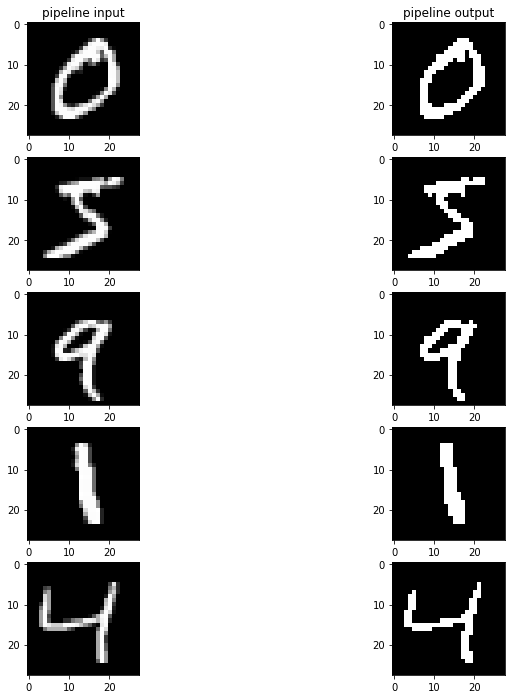

In [7]:
sample_num = 5

fig, axs = plt.subplots(sample_num, 2, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")


for i, j in enumerate(np.random.randint(low=0, high=batch_size-1, size=sample_num)):
    img_in = data_xin.numpy()[j]
    axs[i,0].imshow(img_in, cmap="gray")
    
    img_out = data_xout.numpy()[j,:,:,0]
    axs[i,1].imshow(img_out, cmap="gray")
    

## Step 2 - `Network` construction
**FastEstimator supports both PyTorch and TensorFlow, so this section could use either backend.** <br>
We are going to only demonstrate the TensorFlow backend in this example.

### Model construction
Both of our models' definitions are implemented in TensorFlow and instantiated by calling `fe.build` (which also associates the model with specific optimizers).

In [8]:
LATENT_DIM = 50

def encoder_net():
    infer_model = tf.keras.Sequential()
    infer_model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))
    infer_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'))
    infer_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'))
    infer_model.add(tf.keras.layers.Flatten())
    infer_model.add(tf.keras.layers.Dense(LATENT_DIM + LATENT_DIM))
    return infer_model


def decoder_net():
    generative_model = tf.keras.Sequential()
    generative_model.add(tf.keras.layers.InputLayer(input_shape=(LATENT_DIM, )))
    generative_model.add(tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu))
    generative_model.add(tf.keras.layers.Reshape(target_shape=(7, 7, 32)))
    generative_model.add(
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))
    generative_model.add(
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))
    generative_model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation='sigmoid'))
    return generative_model

encode_model = fe.build(model_fn=encoder_net, optimizer_fn="adam", model_name="encoder")
decode_model = fe.build(model_fn=decoder_net, optimizer_fn="adam", model_name="decoder")

### Customize `Ops` 
`Ops` are the basic components of a `Network`. They can be logic for loss calculation, model update units, or even the model itself. Some `Ops` such as cross entropy are pre-defined in FastEstimator, but for any logic that is not there yet, users need to define their own `Ops`. **Please keep all custom `Ops` backend-consistent with your model backend**. In this case all `Ops` need to be implemented in TensorFlow since our model is built from Tensorflow.      

#### Customize Ops - SplitOp
Because the encoder output contains both mean and log of variance, we need to split them into two outputs: 

In [9]:
from fastestimator.op.tensorop import TensorOp

class SplitOp(TensorOp):
    """To split the infer net output into two """
    def forward(self, data: tf.Tensor, state: Dict[str, Any]) -> Tuple[tf.Tensor, tf.Tensor]:
        mean, logvar = tf.split(data, num_or_size_splits=2, axis=1)
        return mean, logvar

#### Customize Ops - ReparameterizeOp
In this example case, the input to the decoder is a random sample from a normal distribution whose mean and variation are the output of the encoder. We are going to build an `Op` called "ReparameterizeOp" to accomplish this:

In [10]:
class ReparameterizeOp(TensorOp):
    def forward(self, data: Tuple[tf.Tensor, tf.Tensor], state: Dict[str, Any]) -> tf.Tensor:
        mean, logvar = data
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

#### Customize Ops - CVAELoss

In [11]:
import math

class CVAELoss(TensorOp):
    def forward(self, data: Tuple[tf.Tensor, ...], state: Dict[str, Any]) -> tf.Tensor:
        cross_ent_mean, mean, logvar, z = data   
        
        cross_ent_total = cross_ent_mean * (28 * 28 * 1) # cross_ent_mean is the average cross entropy over pixels and batches 
                                                         # make it total cross entropy over pixels 
        logpz = self._log_normal_pdf(z, 0., 0.)
        logqz_x = self._log_normal_pdf(z, mean, logvar)
        total_loss = cross_ent_total + tf.reduce_mean(-logpz + logqz_x)

        return total_loss
    
    @staticmethod
    def _log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * tf.constant(math.pi))
        return tf.reduce_sum(-.5 * ((sample - mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

### `Network` definition
We are going to connect all models and `Ops` together into a `Network` 

In [12]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

network = fe.Network(ops=[
    ModelOp(model=encode_model, inputs="x_out", outputs="meanlogvar"),
    SplitOp(inputs="meanlogvar", outputs=("mean", "logvar")),
    ReparameterizeOp(inputs=("mean", "logvar"), outputs="z"), 
    ModelOp(model=decode_model, inputs="z", outputs="x_logit"),
    CrossEntropy(inputs=("x_logit", "x_out"), outputs="cross_entropy"), 
    CVAELoss(inputs=("cross_entropy", "mean", "logvar", "z"), outputs="loss", mode="!infer"),
    UpdateOp(model=encode_model, loss_name="loss"),
    UpdateOp(model=decode_model, loss_name="loss"),
])

## Step 3 - `Estimator` definition and training
In this step, we define the `Estimator` to compile the `Network` and `Pipeline` and indicate in `traces` that we want to save the best models. We can then use `estimator.fit()` to start the training process:

In [13]:
from fastestimator.trace.io import ModelSaver

traces = [ModelSaver(model=encode_model, save_dir=save_dir, frequency=epochs), 
          ModelSaver(model=decode_model, save_dir=save_dir, frequency=epochs)]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         log_steps=600)

estimator.fit() # start the training process

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 1; logging_interval: 600; 


FastEstimator-Train: step: 1; loss: 547.3221; 
FastEstimator-Train: step: 10; epoch: 1; epoch_time: 0.77 sec; 


FastEstimator-ModelSaver: Saved model to /tmp/tmp7r15a635/encoder_epoch_2.h5
FastEstimator-ModelSaver: Saved model to /tmp/tmp7r15a635/decoder_epoch_2.h5
FastEstimator-Train: step: 20; epoch: 2; epoch_time: 0.11 sec; 
FastEstimator-Finish: step: 20; total_time: 1.56 sec; decoder_lr: 0.001; encoder_lr: 0.001; 


## Inferencing

Once the model is trained, we will try to run our models on some testing data. We randomly select 5 images from the testing dataset and infer them image by image:

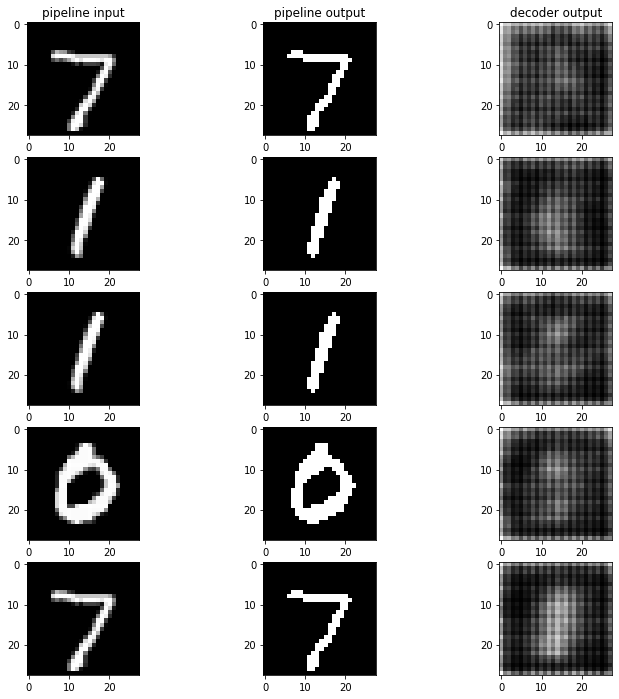

In [14]:
sample_num = 5

fig, axs = plt.subplots(sample_num, 3, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")
axs[0,2].set_title("decoder output")

for i, j in enumerate(np.random.randint(low=0, high=batch_size-1, size=sample_num)):
    data = {"x": test_data["x"][j]}
    axs[i,0].imshow(data["x"], cmap="gray")
    
    # run the pipeline
    data = pipeline.transform(data, mode="infer") 
    img = data["x_out"].squeeze(axis=(0,3))
    axs[i,1].imshow(img, cmap="gray")
    
    # run the network
    data = network.transform(data, mode="infer")
    img = data["x_logit"].numpy().squeeze(axis=(0,3))
    axs[i,2].imshow(img, cmap="gray")